<a href="https://colab.research.google.com/github/Harrisous/AIPI590_XAI_A3/blob/main/XAI_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #03
## Haochen Li
### Case Domain: case 3, recidivism prediction (Defence)
⚖️ Case 3: Recidivism Risk – COMPAS Dataset  
🔍 Scenario  
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

🟦 Defense  
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

# Part #01 Load and explore the assigned dataset and model

In [1]:
# Code in this block is copied from provided material: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
sex_categories = df_compas['sex'].astype('category').cat.categories.tolist()
race_categories = df_compas['race'].astype('category').cat.categories.tolist()
degree_categories = df_compas['c_charge_degree'].astype('category').cat.categories.tolist()

df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [2]:
# Code in this block is copied from provided material: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)

Prediction for Malik Johnson (Recidivism): [0]


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              7214 non-null   int64
 1   sex              7214 non-null   int8 
 2   race             7214 non-null   int8 
 3   priors_count     7214 non-null   int64
 4   juv_fel_count    7214 non-null   int64
 5   juv_misd_count   7214 non-null   int64
 6   juv_other_count  7214 non-null   int64
 7   c_charge_degree  7214 non-null   int8 
 8   two_year_recid   7214 non-null   int64
dtypes: int64(6), int8(3)
memory usage: 359.4 KB


# Part #02 Explainable Techniques
Use at lease two XAI methods (e.g. SHAP, LIME, Anchors) to explain the focus instance

## LIME

In [4]:
!pip install lime==0.2.0.1

In [5]:
import lime
import lime.lime_tabular
class_names=['Low Risk','High Risk']
categorical_features = ['sex','race','c_charge_degree']
categorical_names = {
    1: sex_categories,
    2: race_categories,
    7: degree_categories
}

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values ,
                                                class_names=class_names, # 0 = low risk, 1= high risk
                                                feature_names=features, # from feature filtering
                                                categorical_features=categorical_features, # can be either idx or names
                                                categorical_names=categorical_names) # default kernel_width

exp = explainer.explain_instance(focus_instance_compas.values[0], model_compas.predict_proba, num_features=len(features))
exp.show_in_notebook()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## LIME Analysis
1. The sample(Malik Johnson) was predicted to have low recidivism risk with 90% probability.
2. The features that contributes to low risk are: 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree'; and the features that contributes to high risk are 'age' and 'race'; 'sex' has no contribution to either classification. It is reasonable from the history, since this person has zero juvenile crime(felony, Misdemeanor and other) and only one prior. This history of not commiting crime in the past indicates that this person is of low risk from historical view.
3. Although 'age' and 'race' contributes to high risk category, but they have limited influence towards the final prediction.
4. Denfense: considering the past history and crime level, the original categorization of low risk is reasonable.

## Anchors

In [6]:
!pip install anchor-exp==0.0.2.0

In [7]:
from anchor import anchor_tabular
import warnings
warnings.filterwarnings('ignore')
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    features,
    X_train.values,
    categorical_names)

idx = 100 # sample of explanation
print('Prediction: ', explainer.class_names[model_compas.predict(focus_instance_compas.values[0].reshape(1, -1))[0]])
exp = explainer.explain_instance(focus_instance_compas.values[0], model_compas.predict, threshold=0.70)
# Print the prediction, precision, and coverage
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.4f' % exp.precision())
print('Coverage: %.4f' % exp.coverage())

Prediction:  Low Risk
Anchor: priors_count <= 2.00
Precision: 0.7072
Coverage: 0.6044


## Anchors Interpretation
1. The Anchor rules created for this instance: priors_count <= 2.00 AND age > 25. And the precision is 0.7832. This indicates that within the anchor rules, 78.32% of the preturbation around this anchor rule will be categorized as low risk. And there are 41.09% of the similar samples are covered by this set of anchor rules.
2. Defense: according to the anchor rules of priors_count <= 2.00 AND age > 25 for which this person is suitable, the result has good precision and coverage. With small priors, this person is not a recidivist, and has age larger than 25. Therefore the original judgement is reasonable.

## SHAP

In [8]:
!pip install shap
!pip install --upgrade shap

In [9]:
import shap

X100 = shap.utils.sample(X_train, 100) # 100 instances for use as the background distribution

explainer = shap.TreeExplainer(model_compas, X100) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test)
shap_values_exp = explainer(X_test)

100%|===================| 2883/2886 [03:01<00:00]       

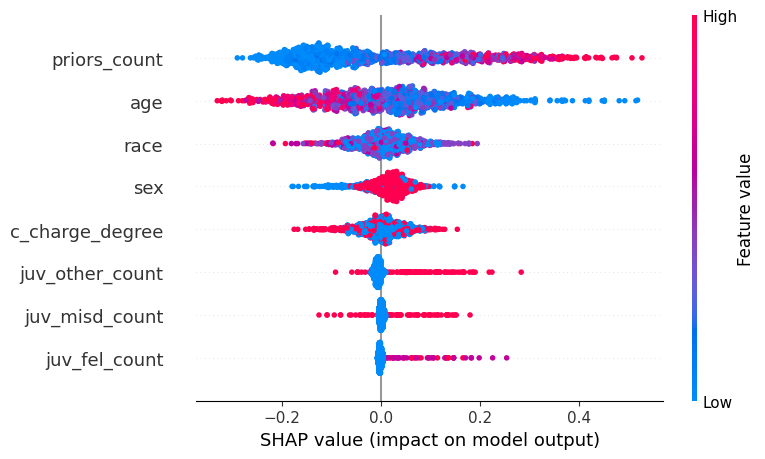

In [10]:
shap.summary_plot(shap_values[:,:,1], X_test)

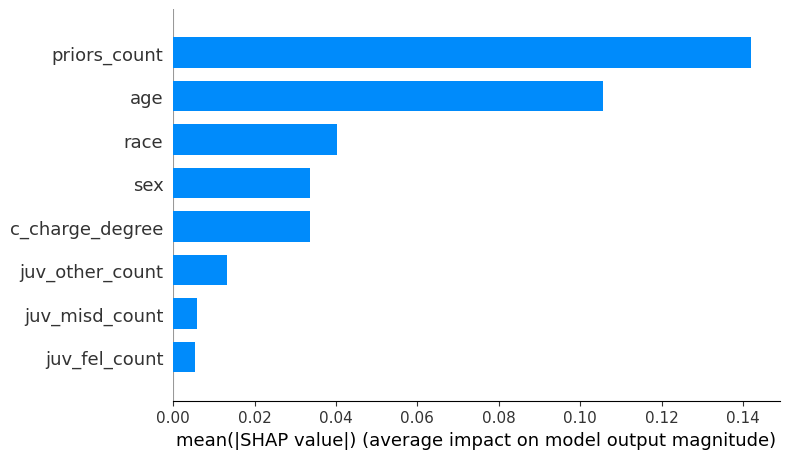

In [11]:
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar")

In [12]:
# single explanation
shap_values = explainer.shap_values(focus_instance_compas)
shap_values_exp = explainer(focus_instance_compas)
print(shap_values_exp)

.values =
array([[[ 0.01983706, -0.01983706],
        [-0.0122755 ,  0.0122755 ],
        [ 0.05178896, -0.05178897],
        [ 0.1544971 , -0.1544971 ],
        [ 0.00596778, -0.00596778],
        [ 0.00126969, -0.00126969],
        [ 0.01418906, -0.01418906],
        [ 0.07826782, -0.07826782]]])

.base_values =
array([[0.58786494, 0.41213506]])

.data =
array([[27,  1,  1,  1,  0,  0,  0,  1]])


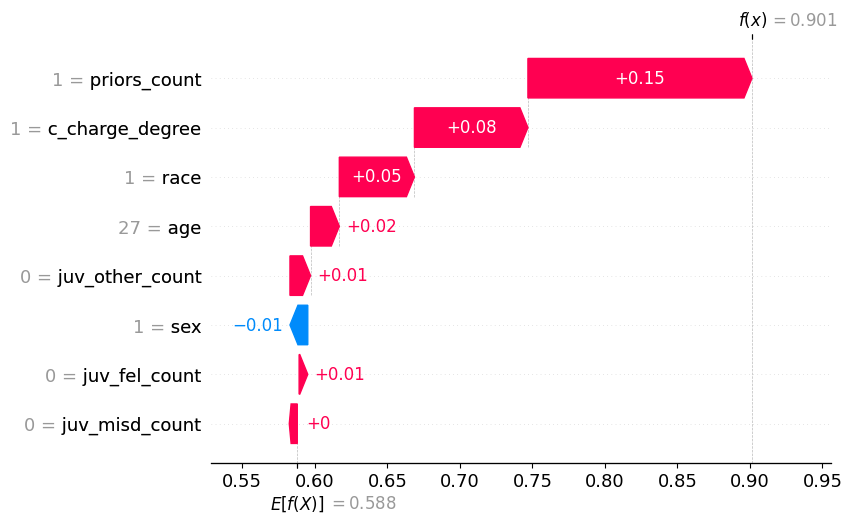

In [13]:
# Following code is generated by Perplexity 9/17 22:59
# old version of SHAP changed the shape of base_value
values = shap_values_exp.values[0][:, 0]
base_value = shap_values_exp.base_values[0][0] # low risk
data = focus_instance_compas.iloc[0]
names = focus_instance_compas.columns

single_explanation = shap.Explanation(
    values=values,
    base_values=base_value,
    data=data,
    feature_names=names
)
shap.plots.waterfall(single_explanation)

## SHAP Analysis
1. From the beewarm plot and bar plot, it is obvious that priors count and age are the most influential factors with Low prior contributing to low risk and high age contributing to low risk. Also, from the beewarm plot we can see that low juvenile crime count (any category) tends to center around zero, which means those juvenile related features have low impact on the final result when they are low.
2. Defense: From the warterfall plot, the base value is 0.588, and the priors_count and c_charge_degree are the two main push towards low risk. And most other features have minor but positive push for low risk and the final value reaches 0.9 which is high enough to be confident about the result. From the plot, the model doesn't treat felony as the indicator for high risk in this case. The final value is close to one and the additive effect is huge from the starting point. Therefore the result is reasonable.
